In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from test_utils import test
from typing import NamedTuple, List, Dict, Tuple

# Load the data

We will be working with the MovieLens dataset, containing 100k movie ratings.
The goal is to predict the rating of a (movie, user) pair, given other ratings by this user and of this movie.

In [2]:
class Dataset(NamedTuple):
    """Data container with three arrays of the same length:"""

    movies: np.ndarray
    users: np.ndarray
    ratings: np.ndarray


def load_data() -> Dataset:
    """Load a sparse matrix from a matlab file and return is as a list of"""
    data = scipy.io.loadmat("movielens100k.mat")["ratings"]
    movies, users = data.nonzero()  # indices of available ratings in the matrix
    ratings = data[movies, users].A1
    return Dataset(movies, users, ratings)


dataset = load_data()

num_users = np.max(dataset.users) + 1
num_movies = np.max(dataset.movies) + 1

print(
    f"Loaded {len(dataset.ratings)} ratings of {num_users} users for {num_movies} movies."
)

Loaded 100000 ratings of 943 users for 1682 movies.


# Plot the number of ratings per movie and user

It will be too tricky to make predictions for movies and users for which too few ratings are available.
Below we will investigate the distribution of how many ratings we have for various users and movies, to evaluate if we need to exclude some users or movies.

In [20]:
def count_ratings_per_movie(dataset: Dataset) -> Dict[int, int]:
    """Count the number of ratings available per movie

    Inputs:
        dataset: Dataset

    Returns:
        counts: a dictionary form movie id (int) -> count (int)

    >>> count_ratings_per_movie(Dataset(np.array([0, 0, 1]), np.array([1, 2, 1]), np.array([1.0, 2.0, 3.0])))
    {0: 2, 1: 1}
    """
    counts = {}
    movie_count = np.unique(dataset.movies,return_counts=True)
    for idx, movie in enumerate(movie_count[0]):
        counts[movie] = movie_count[1][idx]

    return counts


def count_ratings_per_user(dataset: Dataset) -> Dict[int, int]:
    """Count the number of ratings given by a user

    Inputs:
        dataset: Dataset

    Returns:
        counts: a dictionary form user id (int) -> count (int)

    >>> count_ratings_per_user(Dataset(np.array([0, 0, 1]), np.array([1, 2, 2]), np.array([4.0, 1.0, 2.0])))
    {1: 1, 2: 2}
    """
    counts = {}
    user_count = np.unique(dataset.users,return_counts=True)
    for idx, user in enumerate(user_count[0]):
        counts[user] = user_count[1][idx]

    return counts


In [21]:
test(count_ratings_per_movie)
test(count_ratings_per_user)

✅ Your `count_ratings_per_movie` passes some basic tests.
✅ Your `count_ratings_per_user` passes some basic tests.


Let's plot the results:

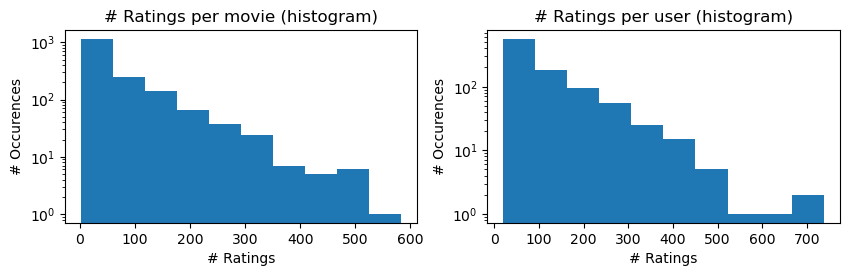

In [114]:
num_ratings_per_movie = count_ratings_per_movie(dataset)
num_ratings_per_user = count_ratings_per_user(dataset)

fig, axes = plt.subplots(ncols=2, figsize=(10, 2.5))
for ax, ratings, unit in zip(
    axes, (num_ratings_per_movie, num_ratings_per_user), ("movie", "user")
):
    ax.hist(ratings.values())
    ax.set_title(f"# Ratings per {unit} (histogram)")
    ax.set_xlabel("# Ratings")
    ax.set_ylabel("# Occurences")
    ax.set_yscale('log')

In [23]:
print(
    "min # of movies per user = {}, \nmin # of users per movie = {}.".format(
        min(num_ratings_per_user.values()), min(num_ratings_per_movie.values())
    )
)

min # of movies per user = 20, 
min # of users per movie = 1.


# Remove movies with too few ratings

As is typical for real-life data, those distributions have a very long tail. There are some movies that have only one rating. Predictions for those will be very unreliable, so we want to take them out of the dataset.

In [65]:
def remove_rare_movies(dataset: Dataset, min_ratings_per_movie=10) -> Dataset:
    """Filter a dataset, and keep only movies with a minimum number of reviews

    Inputs:
        dataset: Dataset
        min_cases: int, the required minimum number

    Returns:
        new dataset: Dataset

    >>> test_dataset = Dataset(np.array([0, 0, 1]), np.array([0, 1, 1]), np.array([1.0, 1.0, 1.0]))
    >>> remove_rare_movies(test_dataset, 2)
    Dataset(movies=array([0, 0]), users=array([0, 1]), ratings=array([1., 1.]))
    """
    num_ratings_per_movie = count_ratings_per_movie(dataset)
    movies = [movie for movie in num_ratings_per_movie.keys() if num_ratings_per_movie[movie]>=min_ratings_per_movie]
    movies_idx = [idx for idx, movie in enumerate(dataset.movies) if movie in movies]
    pruned_dataset = Dataset(
        movies = dataset.movies[movies_idx],
        users = dataset.users[movies_idx],
        ratings = dataset.ratings[movies_idx]
    )
    return pruned_dataset

In [66]:
test(remove_rare_movies)

✅ Your `remove_rare_movies` passes some basic tests.


In [67]:
pruned_dataset = remove_rare_movies(dataset)
print(
    f"There are {len(pruned_dataset.ratings)} ratings left after pruning the dataset."
)

There are 97953 ratings left after pruning the dataset.


# Split the data into a train and test set

In [101]:
def split_dataset(dataset, p_test=0.1, seed=1):
    """
    Split a dataset randomly into a train and a test part

    Inputs:
        dataset: Dataset
        p_test: float
            propability (0 < p_test < 1) for a data point to go into the test set
        seed: integer

    Returns:
        train_dataset: Dataset
        test_dataset: Dataset

    >>> split_dataset(Dataset(np.array([0, 0]), np.array([1, 0]), np.array([2.0, 1.0])), p_test=0)
    (Dataset(movies=array([0, 0]), users=array([1, 0]), ratings=array([2., 1.])), Dataset(movies=array([], dtype=int64), users=array([], dtype=int64), ratings=array([], dtype=float64)))

    >>> split_dataset(Dataset(np.array([0, 0]), np.array([1, 0]), np.array([2.0, 1.0])), p_test=1)
    (Dataset(movies=array([], dtype=int64), users=array([], dtype=int64), ratings=array([], dtype=float64)), Dataset(movies=array([0, 0]), users=array([1, 0]), ratings=array([2., 1.])))
    """
    # use this generator (https://numpy.org/doc/stable/reference/random/index.html)
    # you should use rng.uniform() once inside this function to match the automatic test case
    rng = np.random.default_rng(seed)
    lenght = len(dataset.ratings)
    test_idx = rng.choice(lenght,int(p_test*lenght),replace=False)
    train_idx = np.setdiff1d(np.arange(lenght),test_idx)

    test_data = Dataset(
        movies = dataset.movies[test_idx],
        users = dataset.users[test_idx],
        ratings = dataset.ratings[test_idx]
    )

    train_data = Dataset(
        movies = dataset.movies[train_idx],
        users = dataset.users[train_idx],
        ratings = dataset.ratings[train_idx]
    )

    return train_data, test_data

In [ ]:
test(split_dataset)

In [103]:
train_data, test_data = split_dataset(pruned_dataset, p_test=0.1, seed=10)
print("Number of training points:", len(train_data.ratings))
print("Number of test points:", len(test_data.ratings))

Number of training points: 88158
Number of test points: 9795


# Visualize the dataset
So far, our data has been represented by a list of ratings. We will look at how we can interpret these ratings in a matrix (movies x users) and plot it.

In [107]:
def to_matrix(dataset, num_movies, num_users):
    """
    Construct a dense matrix out of the dataset.

    Input:
        dataset: Dataset

    Output:
        matrix: np.array of floats: (# movies, # users) -> rating (float) or np.NaN if unavailable

    >>> to_matrix(Dataset(np.array([1, 1, 0]), np.array([0, 1, 0]), np.array([1.0, 3.0, 2.5])), 3, 2)
    array([[2.5, nan],
           [1. , 3. ],
           [nan, nan]])
    """
    m = (
        np.zeros([num_movies, num_users]) * np.NaN
    )  # We want NaNs for unavailable ratings
    for movie,user,rating in zip(dataset.movies, dataset.users, dataset.ratings):
        m[movie,user] = rating
    ### HINT: Edit `m` by filling in the available ratings
    return m

In [108]:
test(to_matrix)

✅ Your `to_matrix` passes some basic tests.


Let's plot the train and test dataset 

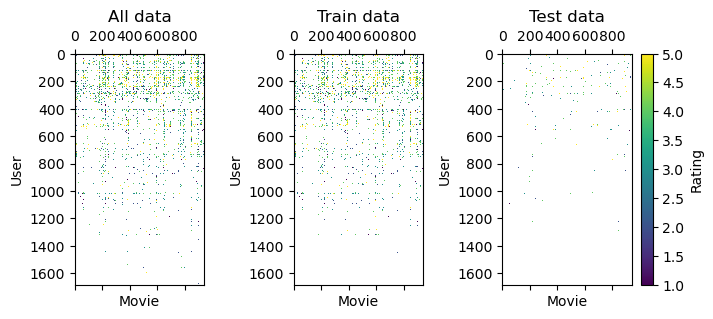

In [111]:
fig, axes = plt.subplots(ncols=3, figsize=(8, 3))
for ax, label, data in zip(
    axes, ("All data", "Train data", "Test data"), (dataset, train_data, test_data)
):
    im = ax.matshow(to_matrix(data, num_movies, num_users))
    ax.set_title(label)
    ax.set_xlabel("Movie")
    ax.set_ylabel("User")
fig.colorbar(im, label="Rating")
plt.show()

# Comparing predictors

The goal of recommender systems is to fill in those matrices. In the remainder of this Notebook, we will implement different methods of making those predictions. Let's first develop the tools to compare them.

Our prediction methods will all have the following form:

In [116]:
class Predictor:
    def __init__(self, train_data: Dataset):
        # This is where you can do any preparation or 'training' if necessary.
        pass

    def __call__(self, test_data: Dataset):
        """
        Make predictions for the users and movies in the test dataset
        (without looking at the ratings).

        Inputs:
            test_data: Dataset (with `n` entries)

        Output:
            predictions: np.array of floats, shape (`n`)
        """
        raise NotImplementedError()

 You would use a predictor like this as follows:
 
 ```
 p = Predictor(train_data)  # this initializes the model. This may include training.
 predictions = p(test_data)  # this calls `__call__` and makes a prediction.
 ```

As an example, a predictor that recommends the same rating everywhere would look like this:

In [126]:
class GlobalMeanPredictor(Predictor):
    """
    Always predict the mean rating from the training set

    >>> train_data = Dataset(np.array([1, 2, 3, 4]), np.array([1, 2, 3, 4]), np.array([1.0, 2.0, 2.0, 5.0]))
    >>> test_data = Dataset(np.array([1, 2, 3, 4]), np.array([2, 1, 4, 0]), np.array([4.0, 1.0, 1.0, 2.0]))
    >>> mean_predictor = GlobalMeanPredictor(train_data)
    >>> mean_predictor(test_data)
    array([2.5, 2.5, 2.5, 2.5])
    """

    def __init__(self, train_data: Dataset):
        self.mean = train_data.ratings.mean()

    def __call__(self, test_data: Dataset):
        return np.full_like(test_data.ratings, fill_value=self.mean)

In [127]:
test(GlobalMeanPredictor)

✅ Your `GlobalMeanPredictor` passes some basic tests.


We can evaluate the predictions using Mean Squared Error:

In [129]:
def mse(predictions, real_ratings):
    """Compute the mean squared prediction error

    Inputs:
        predictions: np.array of floats, shape (n)
        real_ratings: np.array of floats, shape (n)

    Returns:
        mean squared error: float

    >>> mse(np.array([1., 1.2, 2.]), np.array([2., 1., 1.5]))
    0.43
    >>> mse(np.array([4., 2., 1.]), np.array([4., 3., 1.]))
    0.3333333333333333
    """
    return np.mean((real_ratings-predictions)**2)

In [130]:
test(mse)

✅ Your `mse` passes some basic tests.


The error for the global mean predictor can now be computed:

In [131]:
predict_global_mean = GlobalMeanPredictor(train_data)

mse(predict_global_mean(test_data), test_data.ratings)

1.2566583941072602

It is always good to include simple baselines like this one in your machine learning experimentation. We now know that we should at least beat an MSE of `1.24` on the test set.

## Baselines 

We will now gradually make the baseline predictor more complex, by differentiating between users. The idea is that some users will give higher scores on average than others.

### User's mean prediction

Here, to predict the score for a tuple `(movie, user)`, we will return the  average all movie ratings of the `user`.

In [156]:
class UserMeanPredictor(Predictor):
    """
    Predict the mean rating of the user we are predicting for.

    >>> train_data = Dataset(np.array([1, 2, 3, 4]), np.array([1, 2, 2, 0]), np.array([1.0, 2.0, 2.5, 5.0]))
    >>> test_data = Dataset(np.array([1, 2, 3, 4]), np.array([2, 1, 1, 0]), np.array([4.0, 1.0, 1.0, 2.0]))
    >>> mean_predictor = UserMeanPredictor(train_data)
    >>> mean_predictor(test_data)
    array([2.25, 1.  , 1.  , 5.  ])
    """

    def __init__(self, train_data: Dataset):
        self.user_mean = {u: train_data.ratings[np.where(train_data.users==u)[0]].mean() for u in train_data.users}

    def __call__(self, test_data: Dataset):
        return np.array([self.user_mean[u] for u in test_data.users])

In [157]:
test(UserMeanPredictor)

✅ Your `UserMeanPredictor` passes some basic tests.


Is this working better than predicting the global mean?

In [152]:
predict_user_mean = UserMeanPredictor(train_data)

mse(predict_user_mean(test_data), test_data.ratings)

1.0891325079736849

Q: Why would always predicting the user's mean be pretty useless in practice?

Q: If you want, you can improve the predictor by falling back to the global mean in case we haven't seen any ratings of a user before (or not enough of them).

In [161]:
# Q2 implementation
class UserMeanCountPredictor(Predictor):
    """
    Predict the mean rating of the user we are predicting for.

    >>> train_data = Dataset(np.array([1, 2, 3, 4]), np.array([1, 2, 2, 0]), np.array([1.0, 2.0, 2.5, 5.0]))
    >>> test_data = Dataset(np.array([1, 2, 3, 4]), np.array([2, 1, 1, 0]), np.array([4.0, 1.0, 1.0, 2.0]))
    >>> mean_predictor = UserMeanPredictor(train_data)
    >>> mean_predictor(test_data)
    array([2.25, 1.  , 1.  , 5.  ])
    """

    def __init__(self, train_data: Dataset):
        user_count = {u: len(np.where(train_data.users==u)[0]) for u in train_data.users}
        mean = train_data.ratings.mean()
        self.user_mean = {u: train_data.ratings[np.where(train_data.users==u)[0]].mean() if user_count[u] > 15 else mean for u in train_data.users }

    def __call__(self, test_data: Dataset):
        return np.array([self.user_mean[u] for u in test_data.users])
    
predict_user_mean = UserMeanCountPredictor(train_data)
mse(predict_user_mean(test_data), test_data.ratings)

1.0890675854176024

### Movie's mean prediction

Here, to predict the score for a tuple `(movie, user)`, we will return the  average all movie ratings of the `movie`. 

Under what assumption is this a good model?

In [162]:
class MovieMeanPredictor(Predictor):
    """
    Predict the mean rating of the movie, irrespective of the user

    >>> train_data = Dataset(np.array([0, 0, 1, 1, 2]), np.array([1, 2, 3, 4, 5]), np.array([4.0, 1.0, 1.0, 2.0, 1.0]))
    >>> test_data = Dataset(np.array([0, 1, 2, 1]), np.array([1, 2, 2, 0]), np.array([1.0, 2.0, 2.5, 5.0]))
    >>> mean_predictor = MovieMeanPredictor(train_data)
    >>> mean_predictor(test_data)
    array([2.5, 1.5, 1. , 1.5])
    """

    def __init__(self, train_data: Dataset):
        self.movie_mean = {m: train_data.ratings[np.where(train_data.movies==m)[0]].mean() for m in train_data.movies}

    def __call__(self, test_data: Dataset):
        return np.array([self.movie_mean[m] for m in test_data.movies])


In [163]:
test(MovieMeanPredictor)

✅ Your `MovieMeanPredictor` passes some basic tests.


In [164]:
predict_movie_mean = MovieMeanPredictor(train_data)

mse(predict_movie_mean(test_data), test_data.ratings)

1.0371254044716218

### Matrix Factorization

With those baselines, we can implement a more realistic recommendation model that using Matrix Factorization.

- To each movie $i$ in the dataset, we will assign a $d$-dimensional trainable ‘representation vector’ $\mathbf{m}_i$.
- To each user $j$ in the dataset, we will assign a $d$-dimensional trainable ‘representation vector’ $\mathbf{u}_j$.
- You can summarize those representations in two matrices: $\mathbf{M}$ of size `(#movies, d)`, and $\mathbf{U}$ of size `(#users, d)`.
- The predicted score we will give for a movie $i$ and a user $j$ will be the dot product $\mathbf{m}_i \cdot \mathbf{u}_j$.
- You can simultaneously express the predicted scores for all movies and all users as a matrix of size `(#movies, #users)` as the matrix product $\mathbf{M} \mathbf{U}^\top$. This interpretation gives the name to this model.
- Given a training set $T$ with rating triples `(movie i, user j, rating r)`,
  we will optimize the mean squared prediction error $\frac{1}{|T|}\sum_{(i, j, r) \in T} (\mathbf{m}_i \cdot \mathbf{u}_j - r)^2$ over the training set. 

In [187]:
np.random.default_rng(seed=1).normal(0,1,(3,5))[np.array([0,1])]

array([[ 0.34558419,  0.82161814,  0.33043708, -1.30315723,  0.90535587],
       [ 0.44637457, -0.53695324,  0.5811181 ,  0.3645724 ,  0.2941325 ]])

In [190]:
class MatrixFactorizationPredictor(Predictor):
    """
    Predict the rating of a user/movie pair as the dot-product
    of representation vectors of the user and the movie.

    >>> train_data = Dataset(np.array([0, 0, 1, 1, 2]), np.array([1, 2, 3, 4, 5]), np.array([4.0, 1.0, 1.0, 2.0, 1.0]))
    >>> test_data = Dataset(np.array([0, 1, 2, 1]), np.array([1, 2, 2, 0]), np.array([1.0, 2.0, 2.5, 5.0]))
    >>> mean_predictor = MatrixFactorizationPredictor(train_data)
    >>> mean_predictor(test_data)  # the factorization is not yet optimized here
    array([ 2.62654714, -2.89866225,  0.70909287,  5.29901482])
    """

    def __init__(self, train_data: Dataset, num_features=20, seed=1):
        # Randomly initialize features for the users and the movies from N(0, 1)

        # use this generator (https://numpy.org/doc/stable/reference/random/index.html)
        # you are expected to use rng.normal() twice in this function to match the tests, once for movies, and then once for users
        rng = np.random.default_rng(seed)

        num_movies = np.max(train_data.movies) + 1
        num_users = np.max(train_data.users) + 1
        self.movie_features = rng.normal(0,1,size=(num_movies,num_features))
        self.user_features = rng.normal(0,1,size=(num_users,num_features))

        # Normally, you should train the model here, but we will skip this
        # for now, to be able to take it step-by-step.

    def __call__(self, test_data: Dataset):
        return np.array([self.movie_features[m] @ self.user_features[u].T for m,u in zip(test_data.movies,test_data.users)])

In [191]:
test(MatrixFactorizationPredictor)

✅ Your `MatrixFactorizationPredictor` passes some basic tests.


Without training, the `MatrixFactorizationPredictor` would not perform so well:

In [192]:
predict_global_mean = MatrixFactorizationPredictor(train_data)

mse(predict_global_mean(test_data), test_data.ratings)

33.510638638944506

### Optimize the factorization using SGD

One way to optimize the representation vectors for movies and users, is to sample terms from the following loss function:

$$\frac{1}{|T|}\sum_{(i, j, r) \in T} (\mathbf{m}_i \cdot \mathbf{u}_j - r)^2$$

and optimize the sampled $\mathbf{m}_i$ and $\mathbf{u}_j$ using a stochastic gradient descent step.

To improve generalization, we will add L2 regularization (also known as `weight decay`) to this model, both for the movie representations as well as for the user representations. Because those weights are unique for each movie / user, you should also sample those stochastically. If you sample a triple `(i, j, r)`, you should minimize:

$$ (\mathbf{m}_i \cdot \mathbf{u}_j - r)^2 + \lambda_\text{movie} \left\lVert\mathbf{m}_i\right\rVert^2 + \lambda_\text{user} \left\lVert\mathbf{u}_j\right\rVert^2$$

You should start by computing a gradient for this term.

In [228]:
learning_rate = 0.02
weight_decay_movie = 0.3
weight_decay_user = 0.3

predictor = MatrixFactorizationPredictor(train_data)
rng = np.random.default_rng(0)
for epoch in range(20):
    # Shuffle the dataset
    datapoint_indices = rng.permutation(len(train_data.ratings))
    for point in datapoint_indices:
        movie = train_data.movies[point]
        user = train_data.users[point]
        rating = train_data.ratings[point]

        # Optimize the factorizations in `predictor` using an SGD
        # step based on the datapoint (movie, user, rating).
        movie_grad = 2*(predictor.movie_features[movie] @ predictor.user_features[user].T - rating)*predictor.user_features[user] + 2*weight_decay_movie*predictor.movie_features[movie]
        user_grad = 2*(predictor.movie_features[movie] @ predictor.user_features[user].T - rating)*predictor.movie_features[movie] + 2*weight_decay_movie*predictor.user_features[user]

        predictor.movie_features[movie] = predictor.movie_features[movie] - learning_rate * movie_grad
        predictor.user_features[user] = predictor.user_features[user] - learning_rate * user_grad

    learning_rate *= 0.9  # decay the learning rate after each epoch

    print(
        f"Train error after epoch {epoch+1}: {mse(predictor(train_data), train_data.ratings)}"
    )
    print(
        f"Test error after epoch {epoch+1}: {mse(predictor(test_data), test_data.ratings)}"
    )

Train error after epoch 1: 1.0245345294717099
Test error after epoch 1: 1.2300529233434647
Train error after epoch 2: 0.964632069393544
Test error after epoch 2: 1.0937318334830821
Train error after epoch 3: 0.9703982865880034
Test error after epoch 3: 1.0584396393944502
Train error after epoch 4: 0.955619798424758
Test error after epoch 4: 1.0351986469280874
Train error after epoch 5: 0.9694607359506461
Test error after epoch 5: 1.043191354404911
Train error after epoch 6: 0.9485285589078594
Test error after epoch 6: 1.0158627550199117
Train error after epoch 7: 0.9507976314288241
Test error after epoch 7: 1.0123737925747935
Train error after epoch 8: 0.9572403712247597
Test error after epoch 8: 1.0103796681772046
Train error after epoch 9: 0.9422315637124549
Test error after epoch 9: 1.0011781184459116
Train error after epoch 10: 0.944241628416053
Test error after epoch 10: 1.0020358037016035
Train error after epoch 11: 0.9389555924897931
Test error after epoch 11: 0.9952182939834201

You should expect the test error to go down below 1.0.

Feel free to play with the weight decay parameters and learning rates to improve these results.

### Optimize the factoriziation using Alternating Least Squares

Instead of optimizing the objective

$$\frac{1}{|T|}\sum_{(i, j, r) \in T} (\mathbf{m}_i \cdot \mathbf{u}_j - r)^2 + \lambda_\text{movie} \left\lVert \mathbf{M} \right\rVert^2_\text{F} + \lambda_\text{user} \left\lVert \mathbf{U} \right\rVert^2_\text{F}$$

using SGD by sampling terms, we can also use ‘Alternating Least Squares’. For ALS, we make the observation that, if all users representations $\mathbf{u}_j$ are fixed, optimizing all $\mathbf{m}_i$ is a simple least squares problem. Similarly, if the movie representations $\mathbf{m}_i$ are all fixed, optimizing all $\mathbf{u}_j$ is a simple least squares problem. 

What we will do here, is alternate between the following steps:
- Fix the user representations, and perfectly optimize the movie representations.
- Fix the movie representations, and perfectly optimize the user representations.

In [251]:
np.linalg.solve(movie_features.T.dot(movie_features)+user_regularization*np.eye(features_count), movie_features.T.dot(X))

array([[ 2.80125428e-02,  1.87256970e-02, -1.94013222e-02, ...,
         4.29623646e-04, -1.77612530e-02,  1.84254214e-02],
       [-1.00524915e-02,  1.02750023e-02, -1.28240639e-02, ...,
        -5.46113003e-03, -4.39176597e-03,  5.05464450e-02],
       [-3.65948889e-02, -2.12050134e-02,  2.32226393e-05, ...,
        -5.05023636e-03,  1.43292530e-02,  1.14645223e-02],
       ...,
       [-7.00315570e-02,  5.87146780e-04, -1.63853032e-02, ...,
        -6.15301964e-03, -1.19817845e-02, -2.08912340e-02],
       [ 7.50812483e-02,  2.17976615e-02,  2.48142659e-02, ...,
         1.20454816e-02,  2.78994439e-02,  2.09572251e-02],
       [-8.99926779e-03,  2.92294023e-02,  2.32021351e-03, ...,
         8.93333842e-03,  3.05657177e-02,  4.14945247e-02]])

In [266]:
movie_regularization = 20
user_regularization = 20
max_iterations = 1000
stop_criterion = 1e-4

predictor = MatrixFactorizationPredictor(train_data)
user_features = predictor.user_features
movie_features = predictor.movie_features
features_count = user_features.shape[1]
rng = np.random.default_rng(0)

prev_train_error = None

num_movies = np.max(train_data.movies) + 1
num_users = np.max(train_data.users) + 1
X = np.nan_to_num(to_matrix(train_data,num_movies,num_users))

for iteration in range(max_iterations):
    # Optimize the user features
    for user in np.unique(train_data.users):
        # Update `user_features[user]` by optimizing the regularized corresponding least squares objective
        mask = train_data.users == user
        user_movies = train_data.movies[mask]

        predictor.user_features[user] = np.linalg.solve(movie_features.T.dot(movie_features)+user_regularization*np.eye(features_count), movie_features.T.dot(X)).T[0]

    # Optimize the movie features using least squares
    for movie in np.unique(train_data.movies):
        # Update `movie_features[movie]` by optimizing the regularized corresponding least squares objective
        mask = train_data.movies == movie
        movie_users = train_data.users[mask]

        predictor.movie_features[movie] = np.linalg.solve(user_features.T.dot(user_features)+movie_regularization*np.eye(features_count), user_features.T.dot(X.T)).T[0]

    train_error = mse(predictor(train_data), train_data.ratings)
    print(f"Train error after step {iteration+1}: {train_error}")
    print(
        f"Test error after step {iteration+1}: {mse(predictor(test_data), test_data.ratings)}"
    )

    # Stop if the training error is not going down more than 'stop_criterion'
    if (prev_train_error is not None):
        if (train_error - prev_train_error < stop_criterion):
            break
    prev_train_error = train_error

Train error after step 1: 7.799728550278607
Test error after step 1: 7.768028478694448
Train error after step 2: 8.981474100305427
Test error after step 2: 8.946057963755315
Train error after step 3: 9.073722578864597
Test error after step 3: 9.038028724046555
Train error after step 4: 9.081064952168264
Test error after step 4: 9.045349063276868
Train error after step 5: 9.089023976910447
Test error after step 5: 9.053284215064545
Train error after step 6: 9.092692196518874
Test error after step 6: 9.056941435990506
Train error after step 7: 9.094572640838724
Test error after step 7: 9.058816243037736
Train error after step 8: 9.095664013470678
Test error after step 8: 9.059904344218017
Train error after step 9: 9.096497945875822
Test error after step 9: 9.060735777016502
Train error after step 10: 9.097299709219191
Test error after step 10: 9.061535137301062
Train error after step 11: 9.09813909520483
Test error after step 11: 9.062372007596126


KeyboardInterrupt: 

You should find that this beats the simple baselines.
Using default SGD parameters, the alternating least squares solution here outperforms it, but by tuning SGD carefully, you should be able to get the same quality.